In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import PowerSpectrumPSF

In [3]:
import tqdm

def _get_psf_variation(func, n=20):
    start = 0
    end = start + 225

    fwhm = np.zeros((n, n))
    g1 = np.zeros((n, n))
    g2 = np.zeros((n, n))

    for j, x in tqdm.tqdm(enumerate(np.linspace(start, end, n)), total=n):
        for i, y in enumerate(np.linspace(start, end, n)):
            _psf = func(x, y)
            _psf = _psf.drawImage(scale=0.25, nx=17, ny=17)
            mom = galsim.hsm.FindAdaptiveMom(_psf)
            fwhm[i, j] = mom.moments_sigma * 0.25 * 2.355
            g1[i, j] = mom.observed_shape.g1
            g2[i, j] = mom.observed_shape.g2
    return fwhm, g1, g2

from mdetsims.plots import plot_psf_model

In [4]:
rng = np.random.RandomState(seed=2834)
noise_level = 0
variation_factor = 5
psf = PowerSpectrumPSF(
    rng=rng, im_width=225, buff=75, scale=0.25, trunc=1, 
    noise_level=noise_level,
    variation_factor=variation_factor)

n = 225
func = lambda x,y: psf.getPSF(galsim.PositionD(x=x, y=y))

fwhm, g1, g2 = _get_psf_variation(func, n=n)

100%|██████████| 225/225 [03:28<00:00,  1.13it/s]


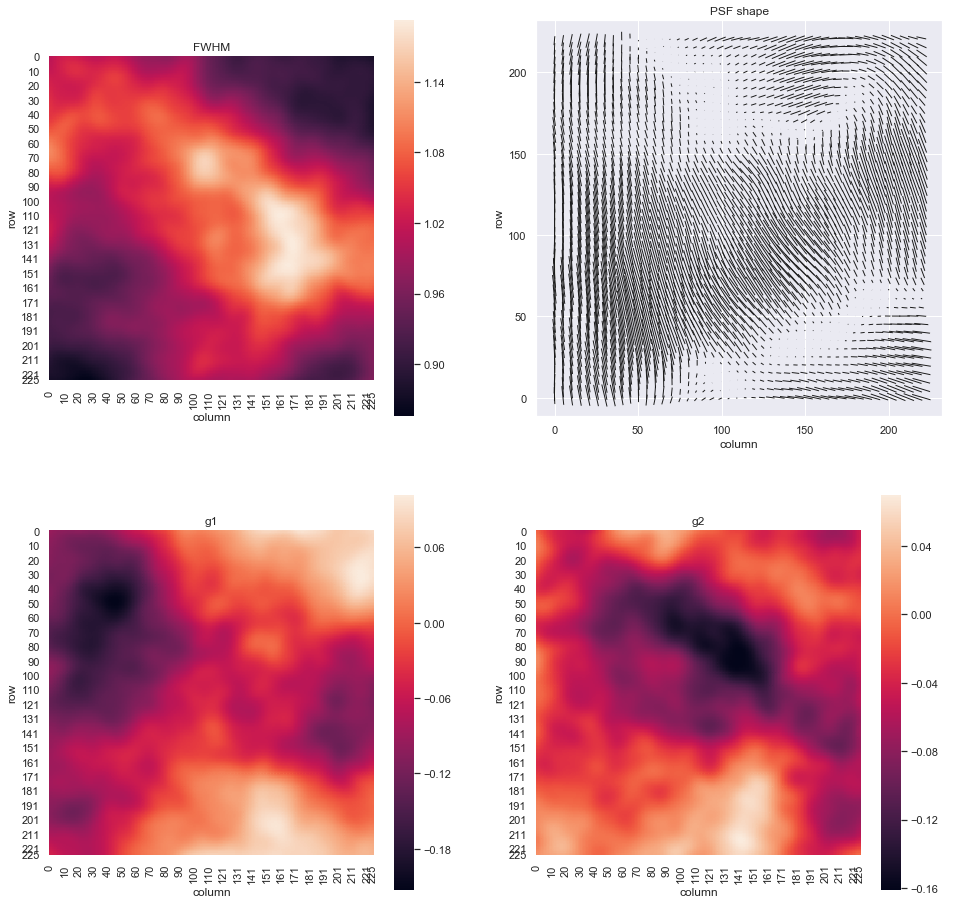

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
plot_psf_model(fwhm, g1, g2, 225, axs)

0.9697065245267515


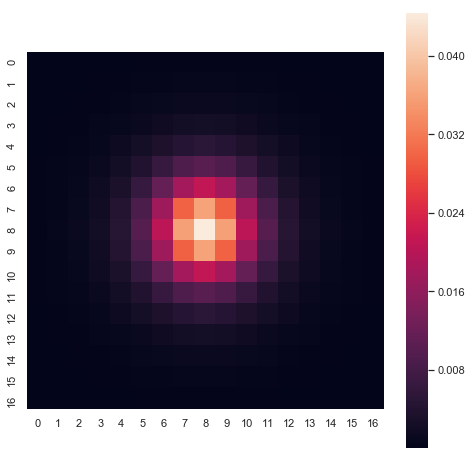

In [17]:
plt.figure(figsize=(8, 8))
psf_im = psf.getPSF(galsim.PositionD(x=10, y=10)).drawImage(scale=0.25, nx=17, ny=17)
print(psf_im.calculateFWHM())
sns.heatmap(psf_im.array, square=True)